In [1]:
%%capture 
!pip install -U pymc-nightly
!pip install numpyro

# SDS 383D Final Project: Swing Decision by Count Effects

The motivation for this project was an area that the Phillies wanted to investigate. The organization uses a swing decision grades model as one of the primary ways they evaluate hitters. These grades are meant to model the expected value of swinging or not swinging at a pitch based on the outcomes of similar pitches and situations. This is useful on a high-level basis to see if players on average are taking good plate approaches to deciding when to swing, and/or seeing the ball well in order to make a good decision.

However, something that is important in the player development realm is coaching players' to have good plate approaches, intelligently expecting and reacting to pitches based on the situation. The current ball-strike count is therefore an important element of evaluating swing decisions, and while it is intrinsically included in the model, there has not been any work done on how players differ in terms of their swing decisions given different counts.

Modeling this would provide value to the organization by allowing coaches to see if players' swing decisions are due to a general problem (eg predicting the ball's trajectory, general overaggressiveness) or situational factors, such as changing their approach with 2 strikes in an attempt to avoid strikeouts. Bayesian Hierarchical modeling is applicable to this situation where players will have varying numbers of pitches seen and swing decisions made, and it is important to gain an understanding of the uncertainty with which these vary. By fitting a linear model with different weights for each count situation, we can model the player's underlying swing decision skill (the intercept) and examine the effects of different counts.

For this project, I also attempted to learn how to use the PyMC API. What follows is my attempts at fitting a model and analyzing the results.

NOTE: Currently this is still a work in progress. I'm having trouble graphing the outputs. Learning this API was more difficult than anticipated but I was too far in to turn back.

## Data organization

In [3]:
%env MKL_THREADING_LAYER=GNU

import os
import warnings
warnings.simplefilter("ignore", UserWarning)

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_gbq as gbq
import pymc as pm
from pymc.sampling_jax import sample_numpyro_nuts

import aesara.tensor as at

print(f"Running on PyMC v{pm.__version__}")

env: MKL_THREADING_LAYER=GNU
Running on PyMC v4.0.0b2


Querying some data:

In [111]:
query_string = """
SELECT
  season,
  level,
  batter_team_id,
  CONCAT(last_name, ", ", first_name) AS batter_name,
  p.batter_id,
  CONCAT(balls, "-", strikes) AS count,
  swing_decision,
  is_swing
FROM
  `phil-new.mesa.play_metrics`
JOIN
  `phil-new.mesa.pitch` p
JOIN
  `phil-new.mesa.player_pro`
ON
  p.batter_id = bam_id
USING
  (play_id)
WHERE
  swing_decision IS NOT NULL
  AND p.level = "MLB"
  AND season = 2022 ;
"""

sd_data = gbq.read_gbq(query_string, project_id="phil-new")

Downloading: 100%|██████████| 135070/135070 [00:16<00:00, 8153.42rows/s]


In [82]:
pitch_counts = sd_data.groupby(["batter_id", "batter_name"]).agg({"swing_decision":"count"}).sort_values("swing_decision").reset_index().rename(columns={"swing_decision":"pitches"})

In [83]:
pitch_counts

,batter_id,batter_name,pitches
0,674677,"Harris, Trey",1
1,677007,"Breaux, Josh",1
2,688410,"Markwardt, Hunter",1
3,682844,"Benitez, Lazaro",1
4,694070,"Garcia, Yhoswar",1
...,...,...,...
1128,656555,"Hoskins, Rhys",545
1129,624413,"Alonso, Pete",557
1130,592450,"Judge, Aaron",560
1131,656941,"Schwarber, Kyle",607


In [322]:
sd_data_counted = sd_data.merge(pitch_counts, on=["batter_name","batter_id"])

In [323]:
qualified = sd_data_counted[sd_data_counted["pitches"] >= 300]["swing_decision"].astype("float")
sd_mean = qualified.mean()
sd_std = qualified.std()

In [324]:
sd_data_counted["swing_decision_normal"] = (sd_data["swing_decision"].astype("float")-sd_mean)/sd_std

Lots of data here! Making a sample to quicken things up in the development phase and then will add more data back in

In [325]:
sd_data_sample = sd_data_counted[:10000]

Distribution of swing decisions:

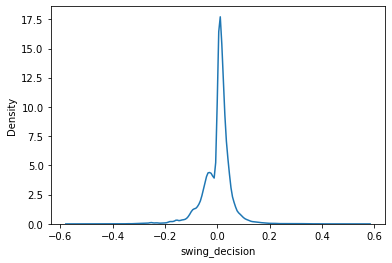

In [273]:
sns.kdeplot(x='swing_decision', data=sd_data);

In [280]:
counts = pd.DataFrame({"intercept": np.ones(len(sd_data_sample))})
counts["2_strikes"] = [1 if x in ["0-2", "1-2", "2-2"] else 0 for x in sd_data_sample["count"]]
counts["3_balls"] = [1 if x in ["3-0", "3-1"] else 0 for x in sd_data_sample["count"]]
counts["full"] = [1 if x == "3-2" else 0 for x in sd_data_sample["count"]]
counts["first"] = [1 if x == "0-0" else 0 for x in sd_data_sample["count"]]
counts["neutral"] = [1 if x in ["1-1", "2-1"] else 0 for x in sd_data_sample["count"]]
# counts = pd.get_dummies(sd_data_sample["count"])
# counts.insert(0, "intercept", np.ones(len(counts)))
column_names = counts.columns
X = counts.to_numpy()

0       2 strikes
1       2 strikes
2         neutral
3       2 strikes
4           first
          ...    
9995        first
9996        first
9997      neutral
9998    2 strikes
9999    2 strikes
Length: 10000, dtype: object

In [327]:
sd = sd_data_sample['swing_decision_normal'].values.T
sd = np.array([float(x) for x in sd])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


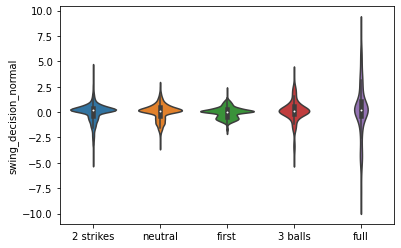

In [329]:
sns.violinplot(counts.drop(columns=["intercept"]).idxmax(axis=1), sd_data_sample["swing_decision_normal"].astype("float"))


### Simple Pooled Linear Regression

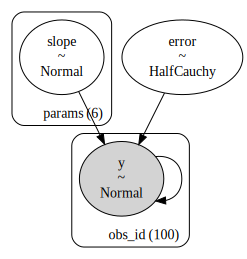

In [198]:
params = column_names
coords = {
    "obs_id": np.arange(len(X)),
    "params": params
}
with pm.Model(coords=coords) as pooled_model:
    b = pm.Normal('slope', 0, 1, dims="params")
    s = pm.HalfCauchy('error', .5)
    obs = pm.Normal('y', X @ b, s, observed=sd, dims="obs_id")
    
pm.model_to_graphviz(pooled_model)

Compiling...
Compilation time =  0:00:01.498939
Sampling...


sample: 100%|██████████| 3000/3000 [00:45<00:00, 65.83it/s]


Sampling time =  0:00:45.771707
Transforming variables...
Transformation time =  0:00:00.021345


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6e2cb7f50>,
      dtype=object)

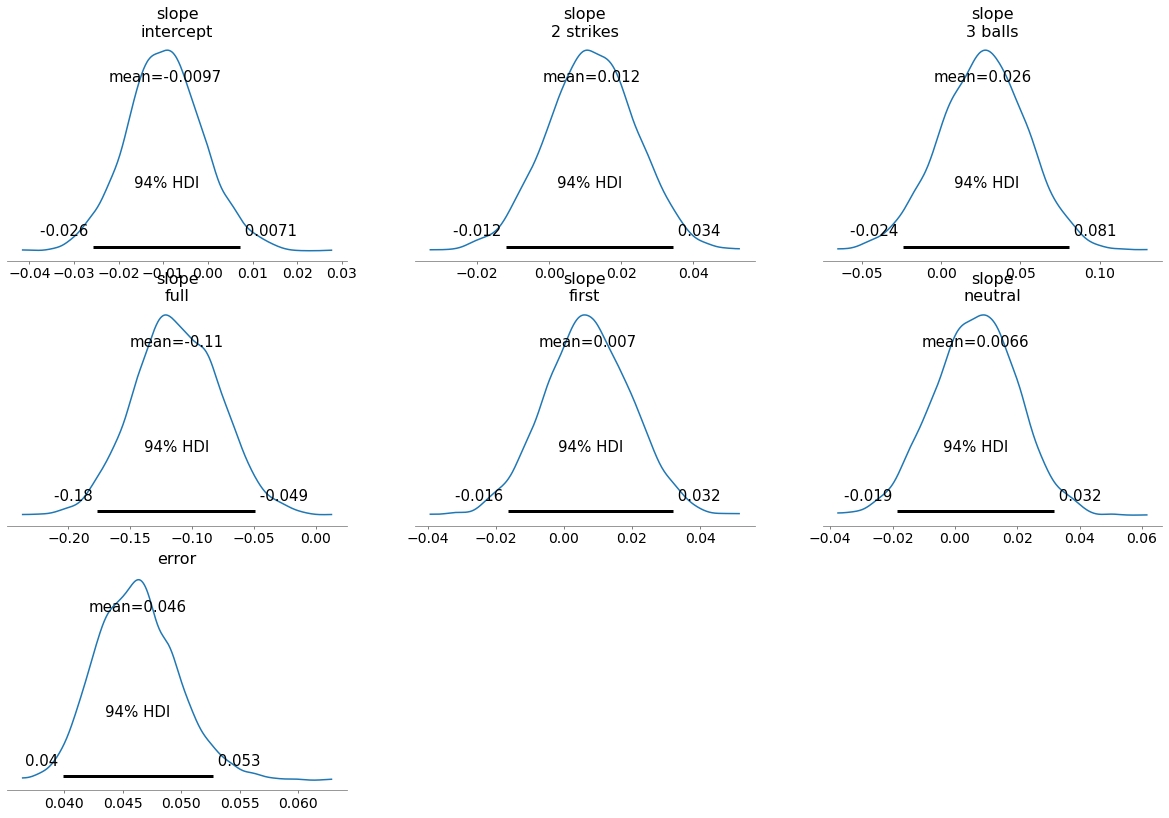

In [199]:
with pooled_model:
    pooled_trace = sample_numpyro_nuts(1000, tune=2000, chain_method='vectorized')
az.plot_posterior(pooled_trace)

In [200]:
with pooled_model:
    ppc = pm.sample_posterior_predictive(pooled_trace)
pooled_trace.extend(ppc)

plot simulations:

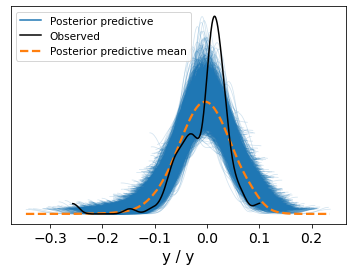

In [201]:
az.plot_ppc(pooled_trace);

T test as a PPC:

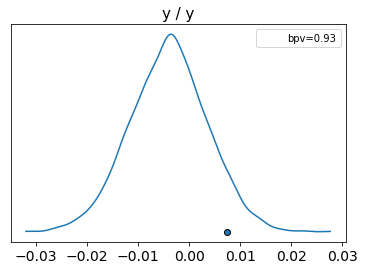

In [202]:
az.plot_bpv(pooled_trace, kind="t_stat", t_stat="median");

/usr/local/lib/python3.7/dist-packages/pymc/data.py:651: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  FutureWarning,


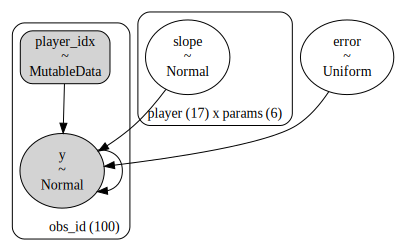

In [209]:
player_idxs, players = pd.factorize(sd_data_sample.batter_name.values)
params = column_names
coords = coords = {
    "player": players,
    "obs_id": np.arange(len(player_idxs)),
    "params": params
}

with pm.Model(coords=coords) as unpooled_model:
    player_idx = pm.Data("player_idx", player_idxs, dims="obs_id")
    b = pm.Normal('slope', 0, 1, dims=("player", "params"))
    s = pm.Uniform('error', 0, 1)
    obs = pm.Normal('y', (X * b[player_idx]).sum(axis=1), s, observed=sd, dims="obs_id")
    
pm.model_to_graphviz(unpooled_model)

In [213]:
with unpooled_model:
    unpooled_trace = sample_numpyro_nuts(1000, tune=500, chain_method='vectorized')

Compiling...
Compilation time =  0:00:02.482235
Sampling...


sample: 100%|██████████| 1500/1500 [05:01<00:00,  4.97it/s]


Sampling time =  0:05:03.058050
Transforming variables...
Transformation time =  0:00:00.028964


Plotting all the individual estimates, we can see there is a lot of uncertainty for some players scenarios and not much for others. This is what is to be expected from an unpooled model, as we just don't have much information for some of these.

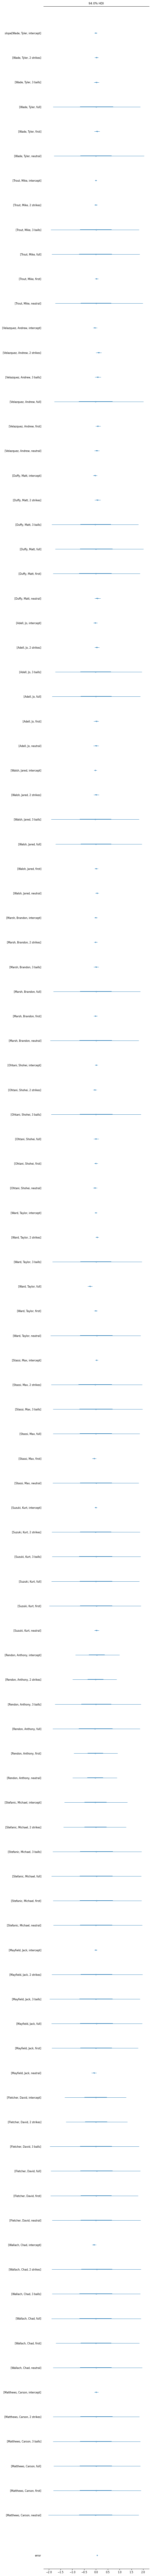

In [220]:
az.plot_forest(
    unpooled_trace,  figsize=(6, 150), r_hat=False, combined=True, textsize=8
);

In [222]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

In [337]:
unpooled_hdi_iter

<xarray.Dataset>
Dimensions:  (hdi: 2, params: 6, player: 17)
Coordinates:
  * player   (player) <U17 'Wade, Tyler' 'Trout, Mike' ... 'Matthews, Carson'
  * params   (params) <U9 '2 strikes' '3 balls' ... 'intercept' 'neutral'
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    slope    (player, params, hdi) float64 -0.06354 0.1077 ... -2.021 1.808
    error    (hdi) float64 0.03778 0.05524

AttributeError: ignored

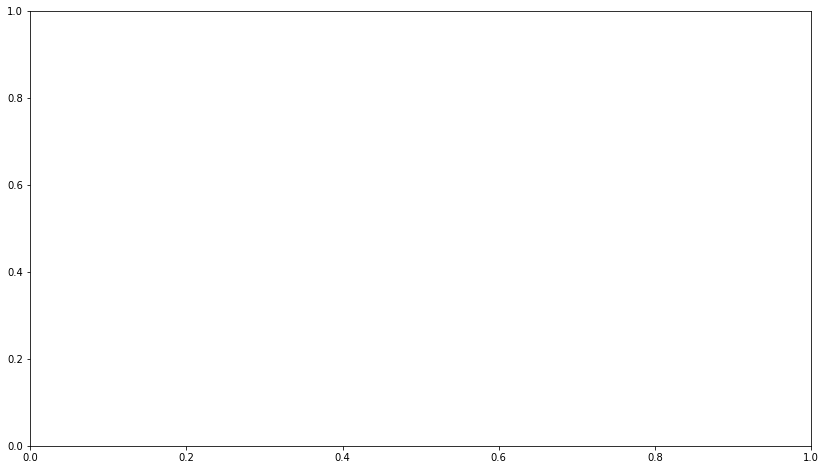

In [336]:
fig, ax = plt.subplots(figsize=(14, 8))

unpooled_means_iter = unpooled_means.sortby("player")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.params)
unpooled_means_iter.plot.scatter(x="player", y="slope", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(sd_data_sample.shape[0]),
    unpooled_hdi_iter.params.sel(hdi="lower"),
    unpooled_hdi_iter.params.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=0.6
)
ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10, trim=True, bottom=True);

In [341]:
player_idxs, players = pd.factorize(sd_data_sample.batter_name.values)
params = column_names
coords = coords = {
    "player": players,
    "obs_id": np.arange(len(player_idxs)),
    "params": params
}

/usr/local/lib/python3.7/dist-packages/pymc/data.py:651: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  FutureWarning,


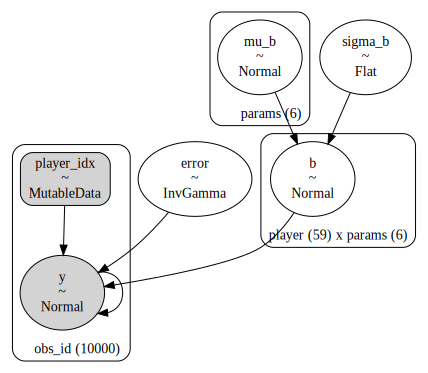

In [342]:
with pm.Model(coords=coords) as partial_pooling:

    player_idx = pm.Data("player_idx", player_idxs, dims="obs_id")
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=1, dims=("params"))
    sigma_b = pm.Flat("sigma_b")
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims=("player", "params"))
    s = pm.InverseGamma('error', .5, .5)
    y = pm.Normal('y', (X * b[player_idx]).sum(axis=1), s, observed=sd, dims="obs_id")
    
pm.model_to_graphviz(partial_pooling)

In [343]:
with partial_pooling:
    partial_pooling_trace = sample_numpyro_nuts(1000, tune=500, chain_method='vectorized')

Compiling...
Compilation time =  0:00:03.634849
Sampling...


sample: 100%|██████████| 1500/1500 [07:44<00:00,  3.23it/s]


Sampling time =  0:07:49.648900
Transforming variables...
Transformation time =  0:00:00.032477


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6e254d510>,
      dtype=object)

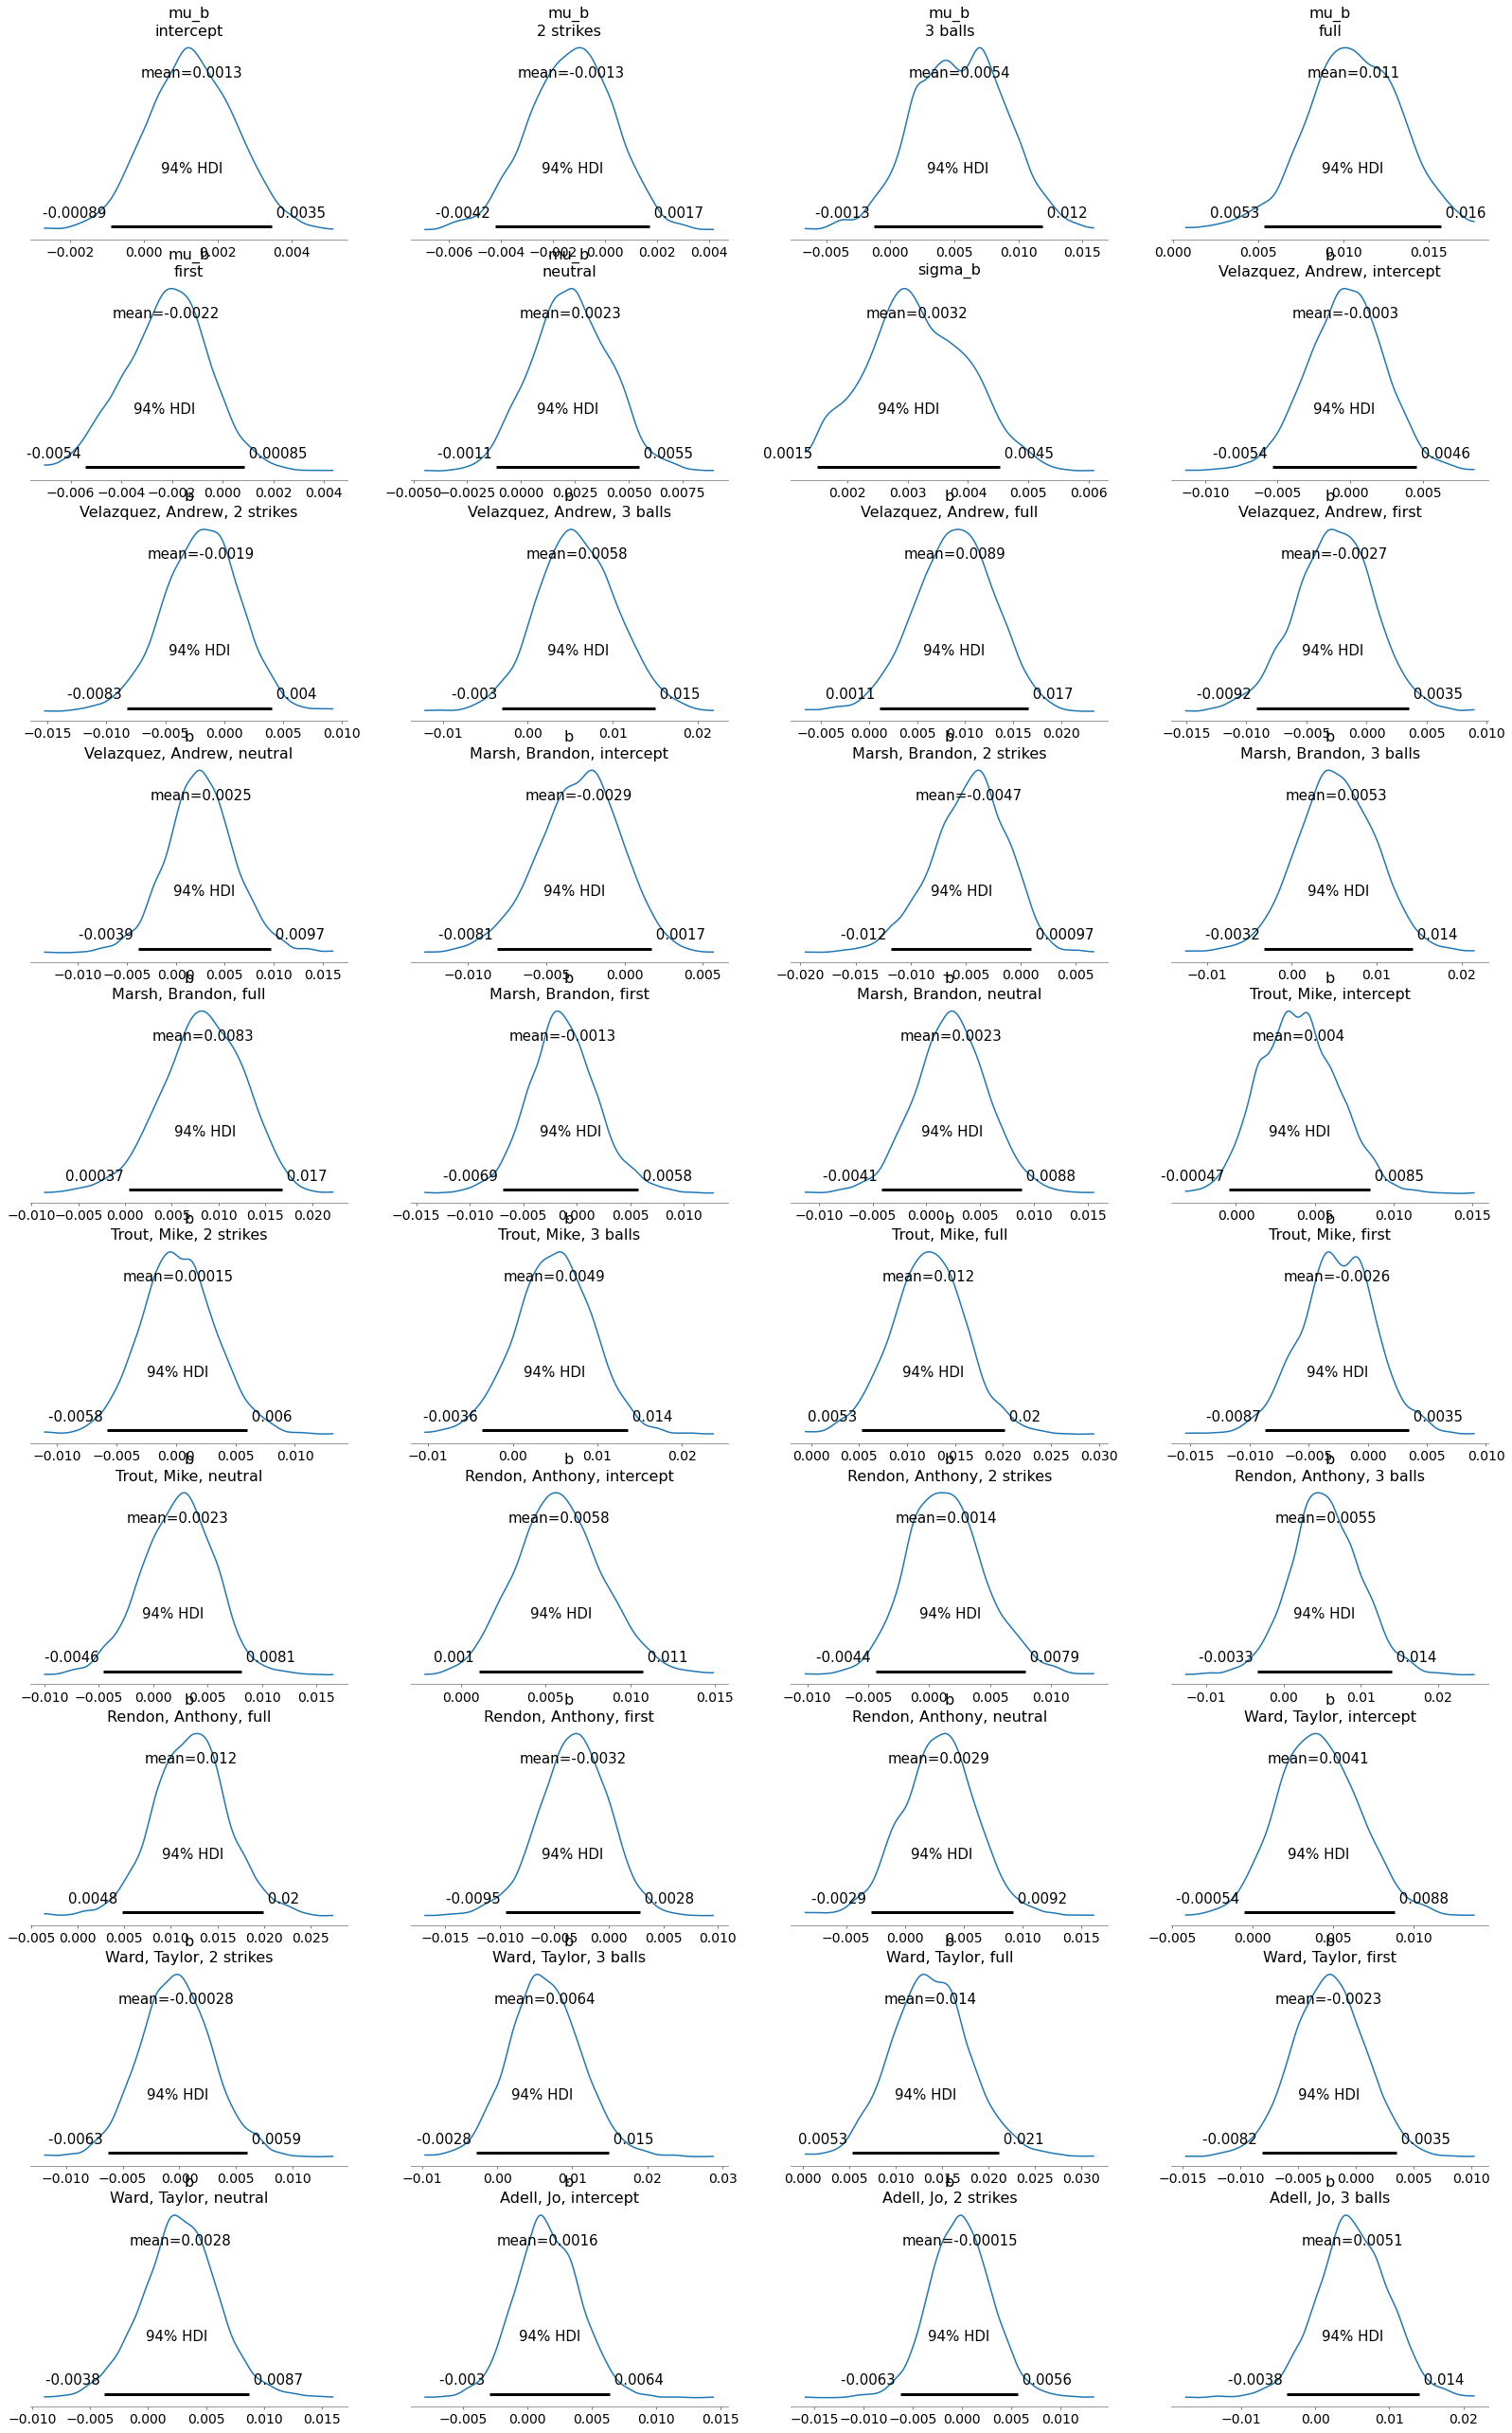

In [260]:
az.plot_posterior(partial_pooling_trace)

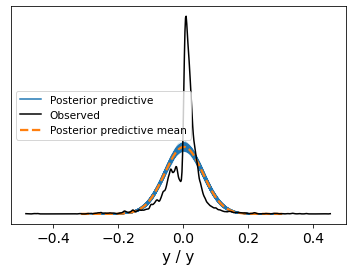

In [261]:
with partial_pooling:
    ppc = pm.sample_posterior_predictive(partial_pooling_trace)
partial_pooling_trace.extend(ppc)
az.plot_ppc(partial_pooling_trace);

In [292]:
sd_data_sample

,season,level,batter_team_id,batter_name,batter_id,count,swing_decision,is_swing
0,2022,MLB,108,"Velazquez, Andrew",623205,0-1,-0.0454503,0
1,2022,MLB,108,"Marsh, Brandon",669016,2-2,0.0023275,1
2,2022,MLB,108,"Trout, Mike",545361,1-1,0.01958,1
3,2022,MLB,108,"Rendon, Anthony",543685,1-0,0.0195235,1
4,2022,MLB,108,"Velazquez, Andrew",623205,0-0,-0.0502323,0
...,...,...,...,...,...,...,...,...
9995,2022,MLB,109,"Varsho, Daulton",662139,0-0,0.0156785,0
9996,2022,MLB,109,"Peralta, David",444482,0-0,0.008559,0
9997,2022,MLB,109,"Varsho, Daulton",662139,1-1,0.0541515,0
9998,2022,MLB,109,"Ellis, Drew",656403,1-2,-0.0087458,1


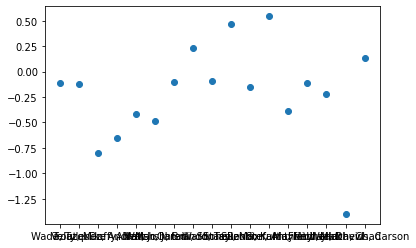

In [318]:
plt.scatter(trace.posterior.mean(dim=("chain", "draw")).sel(params='intercept').player, trace.posterior.mean(dim=("chain", "draw")).sel(params='intercept').slope/sd_std + sd_mean)